In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from IPython.display import display, HTML, JSON
from datetime import datetime

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
%matplotlib inline

# Configuration de seaborn pour de meilleurs graphiques
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Configuration des paramètres de l'API
API_URL="http://localhost:8000"
API_PASSWORD="12345678910"

In [3]:
# Fonctions utilitaires pour interagir avec l'API
def get_token(password, duration=3600):
    """
    Génère un token JWT pour accéder aux endpoints protégés.
    
    Args:
        password (str): Mot de passe de l'API
        duration (int): Durée de validité du token en secondes
        
    Returns:
        str: Token JWT
    """
    url = f"{API_URL}/token"
    payload = {"password": password, "duration": duration}
    
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        return response.json()["token"]
    except requests.exceptions.RequestException as e:
        print(f"Erreur lors de la génération du token: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Détails: {e.response.text}")
        return None

def api_request(endpoint, token=None, params=None):
    """
    Effectue une requête à l'API F1.
    
    Args:
        endpoint (str): Endpoint de l'API à interroger (sans le slash initial)
        token (str): Token JWT pour l'authentification
        params (dict): Paramètres de la requête
        
    Returns:
        dict: Réponse JSON de l'API
    """
    url = f"{API_URL}/{endpoint}"
    headers = {}
    
    if token:
        headers["Authorization"] = f"Bearer {token}"
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Erreur lors de la requête à {endpoint}: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Détails: {e.response.text}")
        return None

def display_json(data):
    """
    Affiche les données JSON de manière formatée.
    
    Args:
        data: Données à afficher (dict ou list)
    """
    if isinstance(data, (dict, list)):
        display(JSON(data))
    else:
        print(data)

In [4]:
# Test de connexion à l'API
# Vérification que l'API est en cours d'exécution
root_response = api_request("")
display_json(root_response)

if root_response and "message" in root_response and root_response["message"] == "F1 API is running":
    print("L'API F1 est en cours d'exécution.")
else:
    print("L'API F1 n'est pas accessible.")

<IPython.core.display.JSON object>

✅ L'API F1 est en cours d'exécution.


In [5]:
# Génération du token avec une durée de validité de 2 heures
token = get_token(API_PASSWORD, duration=7200)

if token:
    print(f"Token JWT généré avec succès.")
    print(f"Token: {token[:20]}...{token[-20:]}")
else:
    print("Échec de la génération du token.")

✅ Token JWT généré avec succès.
Token: eyJhbGciOiJIUzI1NiIs...I5iJ_kWy273c-9fwUpRk


In [6]:
# Récupération des courses pour l'année 2023
year = 2021
races = api_request(f"races/{year}", token=token)

if races and isinstance(races, list):
    print(f"{len(races)} courses récupérées pour l'année {year}.")
    
    # Conversion en DataFrame pour une meilleure visualisation
    races_df = pd.DataFrame(races)
    
    # Conversion de la date en datetime
    if 'date' in races_df.columns:
        races_df['date'] = pd.to_datetime(races_df['date'])
        races_df = races_df.sort_values('date')
    
    display(races_df)
else:
    print(" Échec de la récupération des courses.")
    display_json(races)

✅ 22 courses récupérées pour l'année 2021.


,id,year,round,race_name,circuit,date
0,1036,2021,1,Bahrain Grand Prix,Bahrain International Circuit,2021-03-28
1,1037,2021,2,Emilia Romagna Grand Prix,Autodromo Enzo e Dino Ferrari,2021-04-18
2,1038,2021,3,Portuguese Grand Prix,Autódromo Internacional do Algarve,2021-05-02
3,1039,2021,4,Spanish Grand Prix,Circuit de Barcelona-Catalunya,2021-05-09
4,1040,2021,5,Monaco Grand Prix,Circuit de Monaco,2021-05-23
5,1041,2021,6,Azerbaijan Grand Prix,Baku City Circuit,2021-06-06
6,1042,2021,7,French Grand Prix,Circuit Paul Ricard,2021-06-20
7,1043,2021,8,Styrian Grand Prix,Red Bull Ring,2021-06-27
8,1044,2021,9,Austrian Grand Prix,Red Bull Ring,2021-07-04
9,1045,2021,10,British Grand Prix,Silverstone Circuit,2021-07-18


In [7]:
# Filtrage des courses pour un circuit spécifique
circuit_name = "Circuit de Spa-Francorchamps"
circuit_races = api_request(f"races/{year}", token=token, params={"circuit": circuit_name})

if circuit_races and isinstance(circuit_races, list):
    print(f"{len(circuit_races)} courses récupérées pour le circuit {circuit_name} en {year}.")
    display_json(circuit_races)
else:
    print(f"Aucune course trouvée pour le circuit {circuit_name} en {year}.")
    display_json(circuit_races)

✅ 1 courses récupérées pour le circuit Circuit de Spa-Francorchamps en 2021.


<IPython.core.display.JSON object>

✅ Statistiques récupérées pour Max Verstappen.


,year,races,total_points,wins
0,2015,19,49.0,0
1,2016,21,204.0,1
2,2017,20,168.0,2
3,2018,21,249.0,2
4,2019,21,278.0,3
5,2020,17,214.0,2
6,2021,22,388.5,10
7,2022,22,433.0,15
8,2023,22,530.0,19
9,2024,24,399.0,9


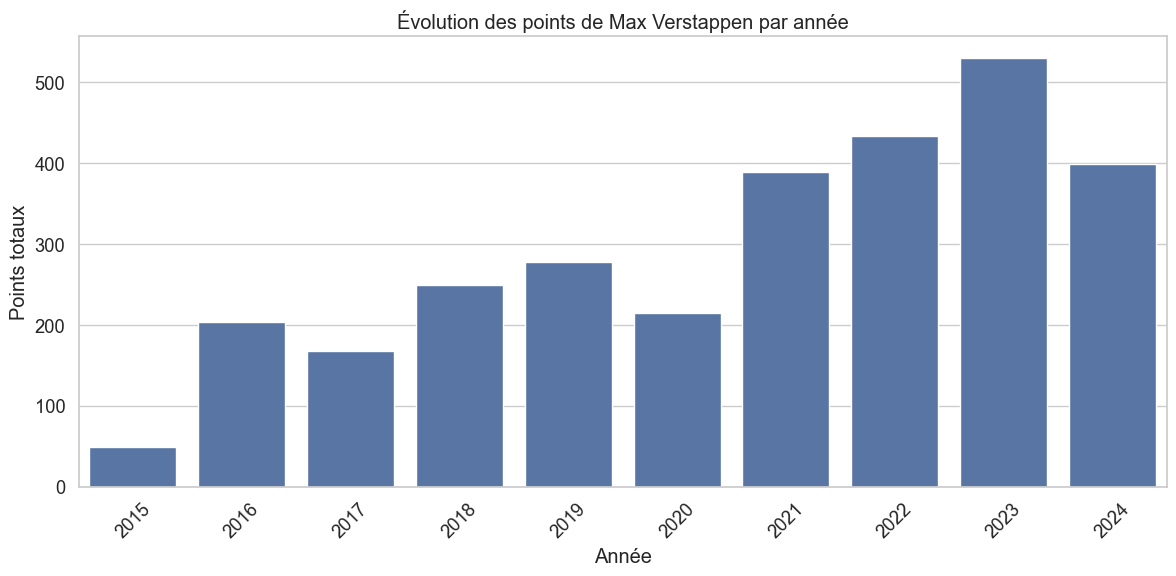

In [8]:
# Récupération des statistiques d'un pilote
driver_name = "Max Verstappen"
driver_stats = api_request(f"driver/{driver_name}", token=token)

if driver_stats and isinstance(driver_stats, list):
    print(f"Statistiques récupérées pour {driver_name}.")
    
    # Conversion en DataFrame pour une meilleure visualisation
    driver_df = pd.DataFrame(driver_stats)
    display(driver_df)
    
    # Création d'un graphique d'évolution des points par année
    if 'year' in driver_df.columns and 'total_points' in driver_df.columns:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='year', y='total_points', data=driver_df)
        plt.title(f"Évolution des points de {driver_name} par année")
        plt.xlabel("Année")
        plt.ylabel("Points totaux")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print(f"Échec de la récupération des statistiques pour {driver_name}.")
    display_json(driver_stats)

In [9]:
# Récupération des statistiques d'un pilote pour une année spécifique
driver_year_stats = api_request(f"driver/{driver_name}", token=token, params={"year": year})

if driver_year_stats and isinstance(driver_year_stats, list):
    print(f"Statistiques récupérées pour {driver_name} en {year}.")
    display_json(driver_year_stats)
else:
    print(f"Échec de la récupération des statistiques pour {driver_name} en {year}.")
    display_json(driver_year_stats)

✅ Statistiques récupérées pour Max Verstappen en 2021.


<IPython.core.display.JSON object>

✅ Performances récupérées pour le circuit de Autodromo Nazionale di Monza.


,year,race_name,avg_speed,max_speed
0,1950,Italian Grand Prix,NaN,NaN
1,1951,Italian Grand Prix,NaN,NaN
2,1952,Italian Grand Prix,NaN,NaN
3,1953,Italian Grand Prix,NaN,NaN
4,1954,Italian Grand Prix,NaN,NaN
...,...,...,...,...
69,2020,Italian Grand Prix,245.358275,357.0
70,2021,Italian Grand Prix,241.148621,347.0
71,2022,Italian Grand Prix,239.892637,343.0
72,2023,Italian Grand Prix,241.061442,348.0


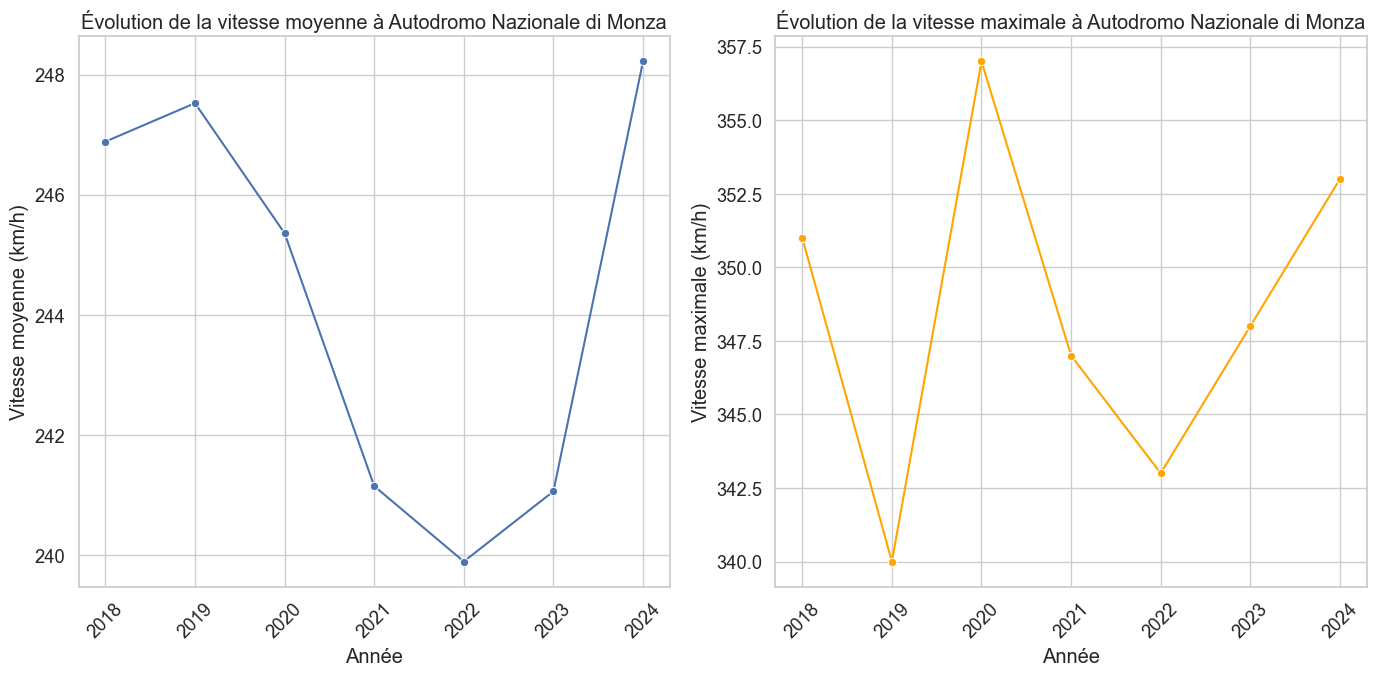

In [10]:
# Analyse des performances sur circuit
circuit_to_analyze = "Autodromo Nazionale di Monza"
circuit_performance = api_request(f"performance/{circuit_to_analyze}", token=token)

if circuit_performance and isinstance(circuit_performance, list):
    print(f"Performances récupérées pour le circuit de {circuit_to_analyze}.")
    
    # Préparation des données pour visualisation
    perf_data = []
    for p in circuit_performance:
        perf_data.append({
            'year': p['_id']['year'] if isinstance(p['_id'], dict) and 'year' in p['_id'] else 'N/A',
            'race_name': p['_id']['race_name'] if isinstance(p['_id'], dict) and 'race_name' in p['_id'] else 'N/A',
            'avg_speed': p.get('avg_speed', 0),
            'max_speed': p.get('max_speed', 0)
        })
    
    perf_df = pd.DataFrame(perf_data)
    display(perf_df)
    
    # Visualisation de l'évolution des vitesses moyennes et maximales
    if 'year' in perf_df.columns:
        plt.figure(figsize=(14, 7))
        
        plt.subplot(1, 2, 1)
        sns.lineplot(x='year', y='avg_speed', data=perf_df, marker='o')
        plt.title(f"Évolution de la vitesse moyenne à {circuit_to_analyze}")
        plt.xlabel("Année")
        plt.ylabel("Vitesse moyenne (km/h)")
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        sns.lineplot(x='year', y='max_speed', data=perf_df, marker='o', color='orange')
        plt.title(f"Évolution de la vitesse maximale à {circuit_to_analyze}")
        plt.xlabel("Année")
        plt.ylabel("Vitesse maximale (km/h)")
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print(f"Échec de la récupération des performances pour le circuit de {circuit_to_analyze}.")
    display_json(circuit_performance)

✅ Classement des Grands Prix récupéré pour 2021.


,id,race_name,circuit,date,total_drivers,max_points,winner
0,1036,Bahrain Grand Prix,Bahrain International Circuit,2021-03-28,20,25.0,Lewis Hamilton
1,1037,Emilia Romagna Grand Prix,Autodromo Enzo e Dino Ferrari,2021-04-18,20,25.0,Max Verstappen
2,1038,Portuguese Grand Prix,Autódromo Internacional do Algarve,2021-05-02,20,25.0,Lewis Hamilton
3,1039,Spanish Grand Prix,Circuit de Barcelona-Catalunya,2021-05-09,20,25.0,Lewis Hamilton
4,1040,Monaco Grand Prix,Circuit de Monaco,2021-05-23,20,25.0,Max Verstappen
5,1041,Azerbaijan Grand Prix,Baku City Circuit,2021-06-06,20,25.0,Sergio Pérez
6,1042,French Grand Prix,Circuit Paul Ricard,2021-06-20,20,26.0,Max Verstappen
7,1043,Styrian Grand Prix,Red Bull Ring,2021-06-27,20,25.0,Max Verstappen
8,1044,Austrian Grand Prix,Red Bull Ring,2021-07-04,20,26.0,Max Verstappen
9,1045,British Grand Prix,Silverstone Circuit,2021-07-18,20,25.0,Lewis Hamilton


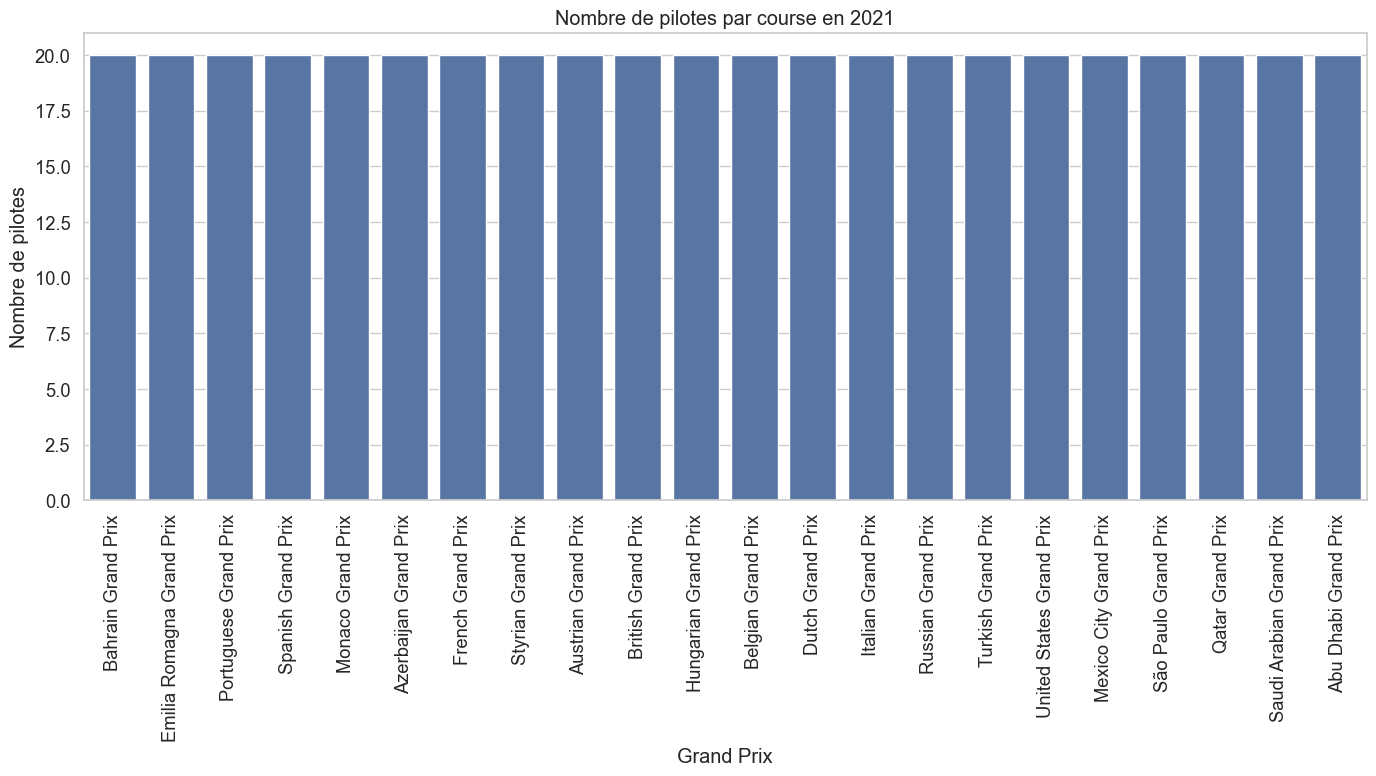

In [11]:
# Récupération du classement des Grands Prix pour une année
championship = api_request(f"championship/races/{year}", token=token)

if championship and isinstance(championship, list):
    print(f"Classement des Grands Prix récupéré pour {year}.")
    
    # Conversion en DataFrame pour une meilleure visualisation
    champ_df = pd.DataFrame(championship)
    
    # Conversion de la date en datetime
    if 'date' in champ_df.columns:
        champ_df['date'] = pd.to_datetime(champ_df['date'])
        champ_df = champ_df.sort_values('date')
    
    display(champ_df)
    
    # Visualisation du nombre de pilotes par course
    if 'race_name' in champ_df.columns and 'total_drivers' in champ_df.columns:
        plt.figure(figsize=(14, 8))
        sns.barplot(x='race_name', y='total_drivers', data=champ_df)
        plt.title(f"Nombre de pilotes par course en {year}")
        plt.xlabel("Grand Prix")
        plt.ylabel("Nombre de pilotes")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
else:
    print(f"Échec de la récupération du classement des Grands Prix pour {year}.")
    display_json(championship)

Test de performances pour l'endpoint: /
  - Temps moyen: 0.0027 secondes
Test de performances pour l'endpoint: /races/2023
  - Temps moyen: 0.0102 secondes
Test de performances pour l'endpoint: /driver/Max Verstappen
  - Temps moyen: 0.0220 secondes
Test de performances pour l'endpoint: /performance/Monaco
  - Temps moyen: 0.6489 secondes
Test de performances pour l'endpoint: /championship/races/2023
  - Temps moyen: 0.0158 secondes


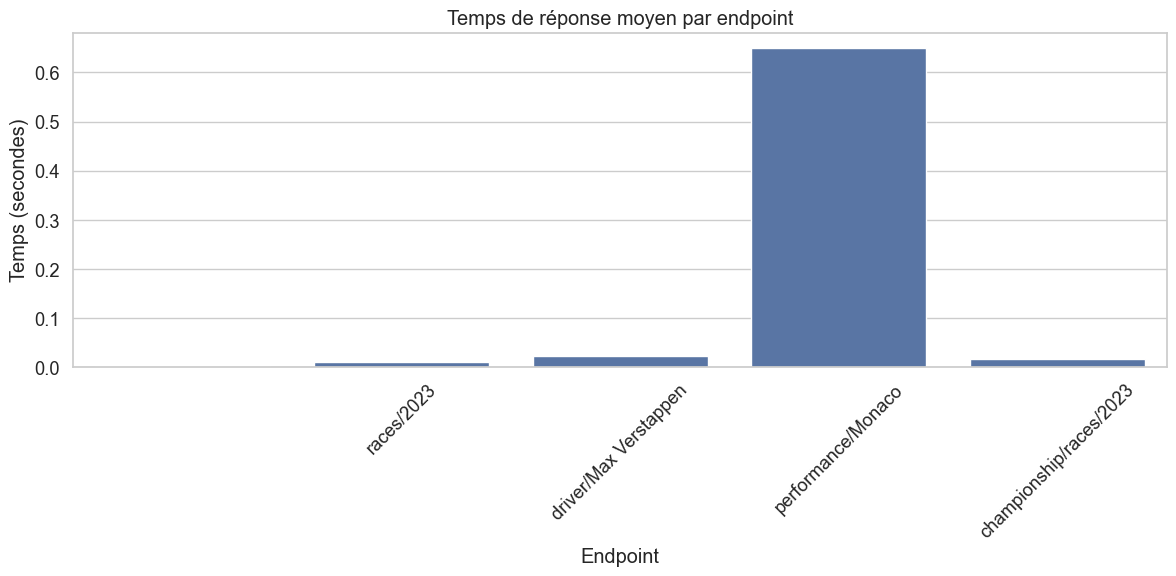

In [12]:
# Test de performances simples (temps de réponse)
import time

def test_endpoint_performance(endpoint, token, iterations=5):
    """
    Teste les performances d'un endpoint en mesurant le temps de réponse moyen.
    
    Args:
        endpoint (str): Endpoint à tester
        token (str): Token JWT valide
        iterations (int): Nombre d'itérations pour le test
    """
    times = []
    
    for i in range(iterations):
        start_time = time.time()
        response = api_request(endpoint, token=token)
        end_time = time.time()
        
        if response is not None:
            times.append(end_time - start_time)
    
    if times:
        avg_time = sum(times) / len(times)
        return {
            "endpoint": endpoint,
            "min_time": min(times),
            "max_time": max(times),
            "avg_time": avg_time,
            "iterations": len(times)
        }
    else:
        return {"endpoint": endpoint, "error": "Aucun test réussi"}

# Tester les performances de quelques endpoints clés
performance_results = []

# Liste des endpoints à tester
endpoints_to_test = [
    "",  # Endpoint racine
    "races/2023",
    "driver/Max Verstappen",
    "performance/Monaco",
    "championship/races/2023"
]

for endpoint in endpoints_to_test:
    print(f"Test de performances pour l'endpoint: /{endpoint}")
    result = test_endpoint_performance(endpoint, token)
    performance_results.append(result)
    print(f"  - Temps moyen: {result.get('avg_time', 'N/A'):.4f} secondes")

# Visualisation des résultats de performance
performance_df = pd.DataFrame(performance_results)
if 'avg_time' in performance_df.columns:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='endpoint', y='avg_time', data=performance_df)
    plt.title("Temps de réponse moyen par endpoint")
    plt.xlabel("Endpoint")
    plt.ylabel("Temps (secondes)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()